## MLB Prediction Analysis
### FiveThirtyEight vs. Fangraphs

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, brier_score_loss
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

def logloss(true_label, predicted, eps=1e-15):
 
    p = np.clip(predicted, eps, 1 - eps)
    
    if true_label == 1:
        return -np.log(p)
    
    else:
        return -np.log(1 - p)
    
    
def plot_calibration_curve(y_true, y_prob, n_bins=5, ax=None, hist=True, normalize=False, title='None'):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, normalize=normalize)
    if ax is None:
        ax = plt.gca()
    if hist:
        if normalize:
            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
        ax.hist(y_prob, weights=np.ones_like(y_prob) / len(y_prob), alpha=.4,
               bins=np.maximum(10, n_bins))
    ax.plot([0, 1], [0, 1], ':', c='k')
    curve = ax.plot(prob_pred, prob_true, marker="o")

    ax.set_xlabel("predicted probability")
    ax.set_ylabel("fraction of positive samples")
    ax.set_title(title)

    ax.set(aspect='equal')
    return curve

In [2]:
reg_games = pd.read_csv('baseball_prediction_showdown.csv')

In [3]:
reg_games['fg_home_pred'] = reg_games['fg_home_prob'].ge(.5)
reg_games['five38_home_pred'] = reg_games['five38_home_prob'].ge(.5)

In [4]:
reg_games['fg_acc'] = reg_games['fg_home_pred'].eq(reg_games['home_win'])
reg_games['five38_acc'] = reg_games['five38_home_pred'].eq(reg_games['home_win'])

reg_games['fg_log_loss'] = reg_games.apply(lambda row: logloss(row['home_win'], row['fg_home_prob']), axis=1)
reg_games['five38_log_loss'] = reg_games.apply(lambda row: logloss(row['home_win'], row['five38_home_prob']), axis=1)

In [5]:
round(reg_games['five38_acc'].mean(),3)

0.577

In [6]:
round(reg_games['fg_acc'].mean(),3)

0.569

In [7]:
((reg_games['five38_home_pred']==reg_games['home_win']).sum() - \
(reg_games['fg_home_pred']==reg_games['home_win']).sum())

58

In [8]:
reg_games['fg_home_win'] = reg_games['fg_home_pred'].ge(.5)
reg_games['five38_home_win'] = reg_games['five38_home_pred'].ge(.5)

In [9]:
rename_cols = {'fg_home_prob': 'Fangraphs',
               'five38_home_prob': 'FiveThirtyEight'}

In [10]:
plt.rcParams.update({'axes.titlesize': 'x-large',
        'xtick.labelsize':'x-large',
         'axes.labelsize': 'x-large',
         'ytick.labelsize':'x-large',
         'legend.fontsize': 'x-large'})

In [11]:
sns.set_palette([sns.color_palette()[2:3][0], sns.color_palette()[1:2][0]])

In [12]:
reg_games = reg_games.rename(columns=rename_cols)

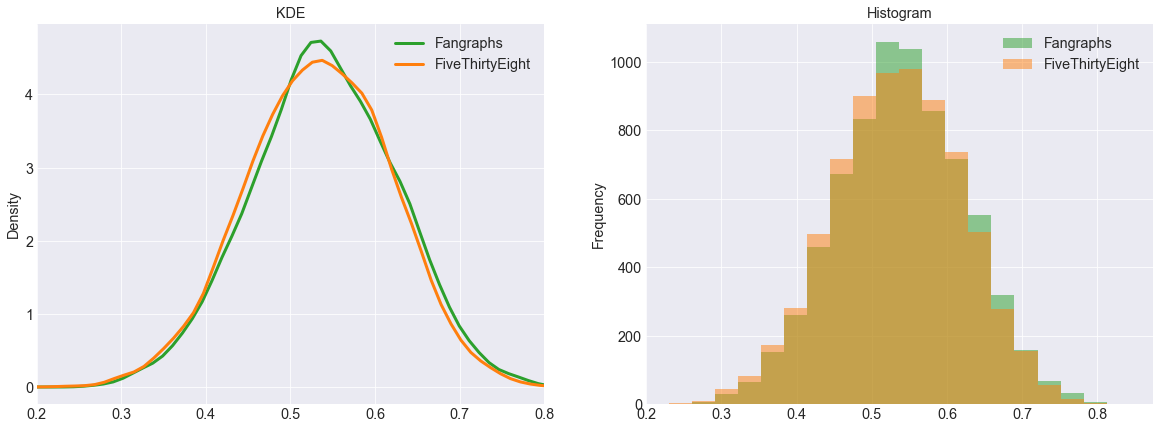

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

(reg_games
[['Fangraphs','FiveThirtyEight']]
.plot(kind='kde', ind=100, ax=ax1, title="KDE", lw='3', xlim=[.2, .8]))

(reg_games
 [['Fangraphs','FiveThirtyEight']]
 .rename(columns=rename_cols)
 .plot(kind='hist',bins=20, alpha=.5, ax=ax2, title='Histogram'))

plt.savefig('prediction_distribution.jpg')

/Users/tpetersen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


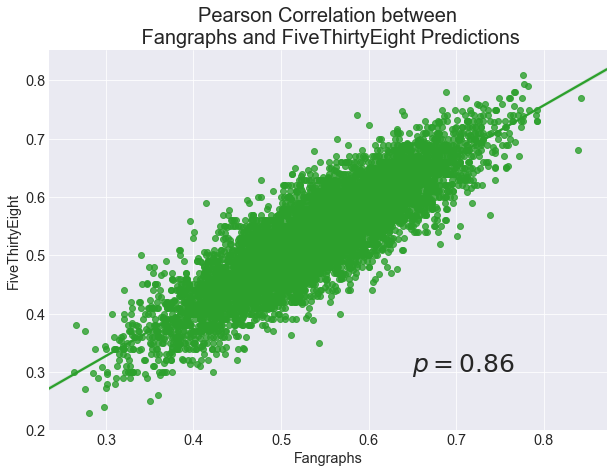

In [14]:
fig, ax = plt.subplots(figsize=(10,7))

sns.regplot(x=reg_games['Fangraphs'],
            y=reg_games['FiveThirtyEight'], ax=ax)

pearson_r = reg_games[['Fangraphs','FiveThirtyEight']].\
            corr()['FiveThirtyEight']['Fangraphs']
    
ax.text(.65, .3, '$p = %0.2f$'%pearson_r, fontsize=25)

ax.set_title('Pearson Correlation between\n Fangraphs and FiveThirtyEight Predictions', size=20)
plt.savefig('correlation_plot.jpg')

In [15]:
reg_games[['Fangraphs','FiveThirtyEight']].describe().round(2)

,Fangraphs,FiveThirtyEight
count,7289.00,7289.00
mean,0.54,0.53
std,0.09,0.08
min,0.26,0.23
25%,0.48,0.48
50%,0.54,0.53
75%,0.60,0.59
max,0.84,0.81


In [16]:
reg_games['home_win'].mean()

0.5325833447660859

## Calibration Plot

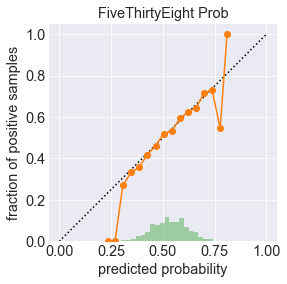

In [17]:
plot_calibration_curve(reg_games['home_win'], reg_games['FiveThirtyEight'], title='FiveThirtyEight Prob', n_bins=25)

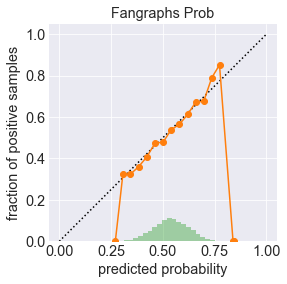

In [18]:
plot_calibration_curve(reg_games['home_win'], reg_games['Fangraphs'], title='Fangraphs Prob', n_bins=25)

## Overall Accuracy

In [19]:
rename_cols = {'fg_acc': 'Fangraphs',
               'five38_acc': 'FiveThirtyEight'}

In [20]:
reg_games[['fg_acc','five38_acc']].mean().round(3)

fg_acc        0.569
five38_acc    0.577
dtype: float64

In [21]:
reg_games['home_naive'] = .532
reg_games['naive_win'] = 1

In [22]:
reg_games['naive_acc'] = reg_games['naive_win'].eq(reg_games['home_win'])

In [23]:
log_loss(y_pred=reg_games['home_naive'], y_true=reg_games['home_win'])

0.6910230098346976

In [24]:
reg_diff = (reg_games
            .groupby('year')
            [['fg_acc','five38_acc','naive_acc']]
             .mean())

In [25]:
reg_diff['fg_acc_diff'] = reg_diff['fg_acc']-reg_diff['naive_acc']
reg_diff['five38_acc_diff'] = reg_diff['five38_acc']-reg_diff['naive_acc']

In [26]:
reg_diff.round(3)

,fg_acc,five38_acc,naive_acc,fg_acc_diff,five38_acc_diff
year,,,,,
2016,0.566,0.568,0.530,0.036,0.037
2017,0.565,0.575,0.540,0.026,0.035
2018,0.577,0.590,0.528,0.049,0.062


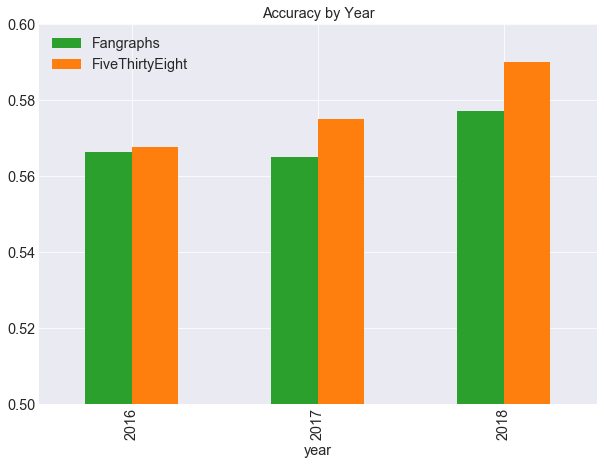

In [27]:
(reg_games
.groupby('year')
[['fg_acc','five38_acc']]
 .mean()
 .rename(columns=rename_cols)
 .plot(kind='bar', ylim=[.5, .6], title='Accuracy by Year', figsize=(10,7))
 )
plt.savefig('accuracy_by_year.jpg')

In [28]:
reg_games[['fg_log_loss','five38_log_loss']].mean().round(4)

fg_log_loss        0.6748
five38_log_loss    0.6754
dtype: float64

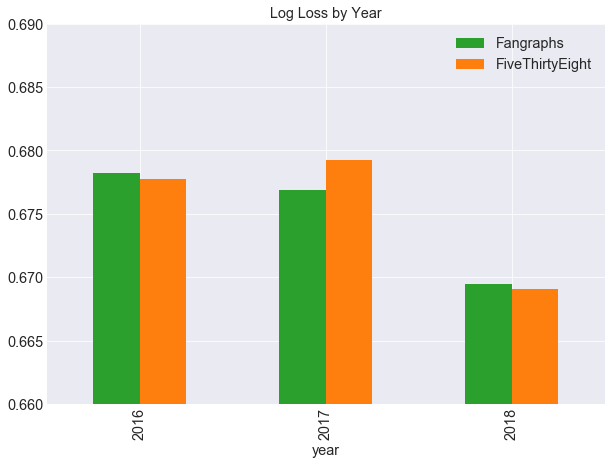

In [29]:
rename_cols = {'fg_log_loss': 'Fangraphs',
               'five38_log_loss': 'FiveThirtyEight'}

(reg_games
.groupby('year')
[['fg_log_loss','five38_log_loss']]
 .mean()
 .rename(columns=rename_cols)
 .plot(kind='bar', ylim=[.66, .69], title='Log Loss by Year', figsize=(10,7))
 )

plt.savefig('logloss_by_year.jpg')

In [30]:
(pd.DataFrame({'Fangraphs Log Loss': [log_loss(y_pred=reg_games['Fangraphs'], y_true=reg_games['home_win'])],
              'FiveThirtyEight Log Loss': [log_loss(y_pred=reg_games['FiveThirtyEight'], y_true=reg_games['home_win'])]})).T.round(4)

,0
Fangraphs Log Loss,0.6748
FiveThirtyEight Log Loss,0.6754


## Precision

In [31]:
(pd.DataFrame({'Fangraphs Precision': [precision_score(y_pred=reg_games['Fangraphs'].ge(.5), y_true=reg_games['home_win'])],
              'FiveThirtyEight Precision': [precision_score(y_pred=reg_games['FiveThirtyEight'].ge(.5), y_true=reg_games['home_win'])]})).T.round(4)

,0
Fangraphs Precision,0.5744
FiveThirtyEight Precision,0.5824


In [32]:
reg_games[['fg_home_pred','five38_home_pred']].sum() / reg_games.shape[0]

fg_home_pred        0.686240
five38_home_pred    0.667856
dtype: float64

## Recall

In [33]:
(pd.DataFrame({'Fangraphs Recall': [recall_score(y_pred=reg_games['Fangraphs'].ge(.5), y_true=reg_games['home_win'])],
              'FiveThirtyEight Recall': [recall_score(y_pred=reg_games['FiveThirtyEight'].ge(.5), y_true=reg_games['home_win'])]})).T.round(4)

,0
Fangraphs Recall,0.7401
FiveThirtyEight Recall,0.7303


## Cumulative Accuracy

In [34]:
def create_cum_accuracy_plot(year):
    acc_d = {'date': [],
        'fg_accuracy': [],
        'five38_accuracy': []}

    for d in pd.date_range(reg_games.query(f'year=={year}')['date'].min(), reg_games.query(f'year=={year}')['date'].max()):
        date = datetime.strftime(d,'%Y-%m-%d')
        fg_acc = accuracy_score(y_pred=reg_games.query(f'year=={year} & date<"{d}"')['Fangraphs'].ge(.5), 
                                y_true=reg_games.query(f'year=={year} & date<"{d}"')['home_win'])
        fig38_acc = accuracy_score(y_pred=reg_games.query(f'year=={year} & date<"{d}"')['FiveThirtyEight'].ge(.5), 
                                   y_true=reg_games.query(f'year=={year} & date<"{d}"')['home_win'])
        acc_d['date'].append(pd.to_datetime(date))
        acc_d['fg_accuracy'].append(fg_acc)
        acc_d['five38_accuracy'].append(fig38_acc)

    fig, ax = plt.subplots(figsize=(10,7))
    pd.DataFrame(acc_d).set_index('date').plot(ax=ax, ylim=[.5,.65])
    ax.set_title(f'{year} Cumulative Accuracy', size=20)
    ax.set_xlim(f'{year}-03-20', f'{year}-10-10')
    ax.legend(['Fangraphs','FiveThirtyEight'])
    plt.savefig(f'cumulative_accuracy_{year}.jpg')

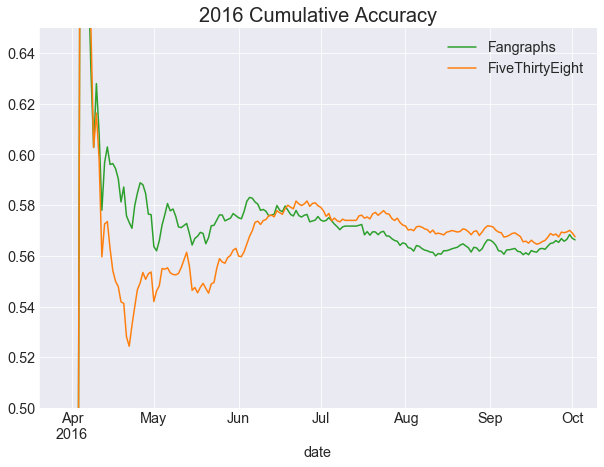

In [35]:
create_cum_accuracy_plot(2016)

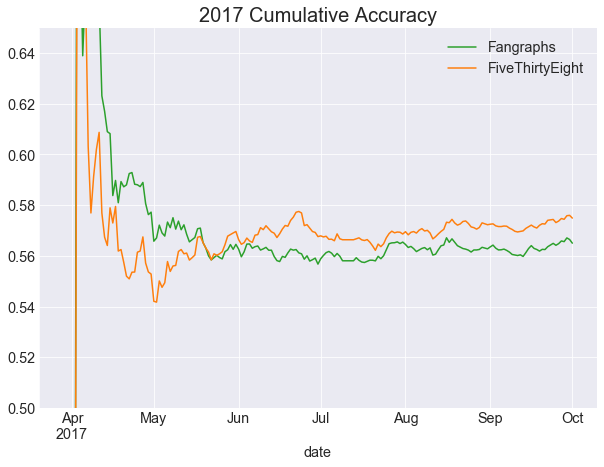

In [36]:
create_cum_accuracy_plot(2017)

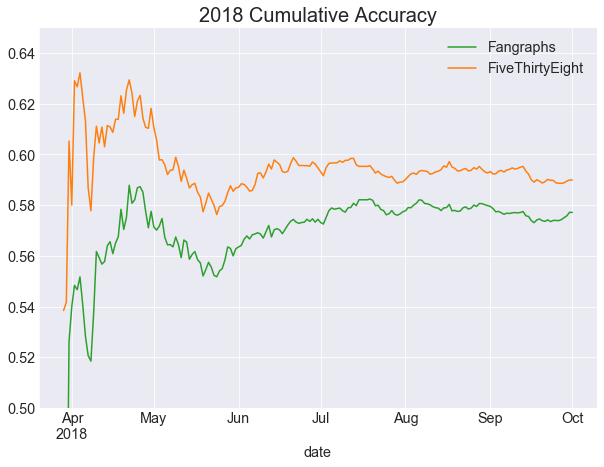

In [37]:
create_cum_accuracy_plot(2018)

## Cumulative Log Loss

In [38]:
def create_cum_logloss_plot(year):
    ll_d = {'date': [],
            'fg_ll': [],
            'five38_ll': []}

    for d in pd.date_range(reg_games.query(f'year=={year}')['date'].min(), 
                           reg_games.query(f'year=={year}')['date'].max()):
        try:
            date = datetime.strftime(d,'%Y-%m-%d')
            fg_ll = log_loss(y_pred=reg_games.query(f'date<"{d}" & year=={year}')['Fangraphs'], 
                             y_true=reg_games.query(f'date<"{d}" & year=={year}')['home_win'])
            five38_ll = log_loss(y_pred=reg_games.query(f'date<"{d}" & year=={year}')['FiveThirtyEight'], 
                                 y_true=reg_games.query(f'date<"{d}" & year=={year}')['home_win'])
            ll_d['date'].append(pd.to_datetime(date))
            ll_d['fg_ll'].append(fg_ll)
            ll_d['five38_ll'].append(five38_ll)
        except:
            continue

    fig, ax = plt.subplots(figsize=(10,7))
    pd.DataFrame(ll_d).set_index('date').plot(ax=ax, ylim=[.65,.7])
    ax.set_title(f'{year} Cumulative Log Loss', size=20)
    ax.set_xlim(f'{year}-03-20', f'{year}-10-10')
    ax.legend(['Fangraphs','FiveThirtyEight'])
    plt.savefig(f'cumulative_logloss_{year}.jpg')

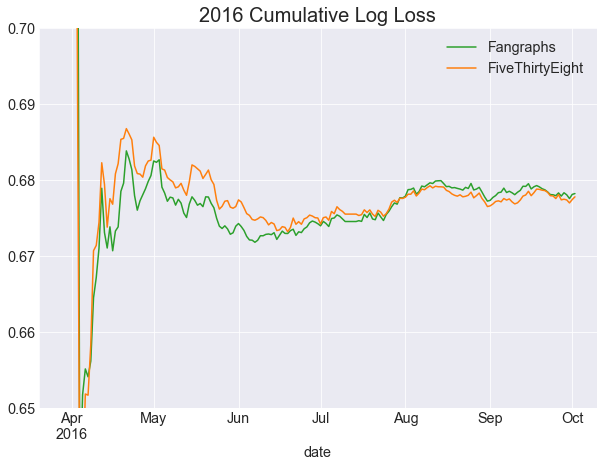

In [39]:
create_cum_logloss_plot(2016)

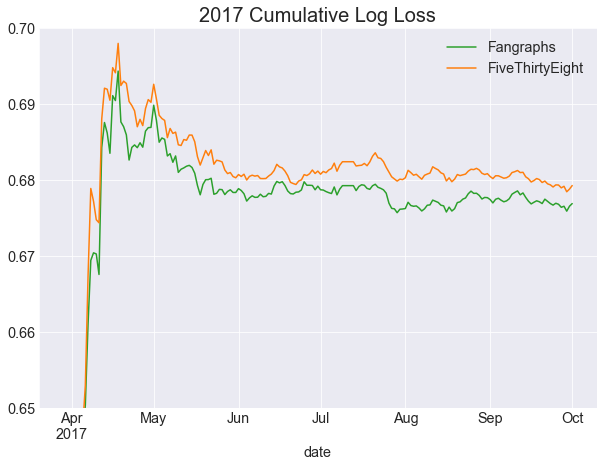

In [40]:
create_cum_logloss_plot(2017)

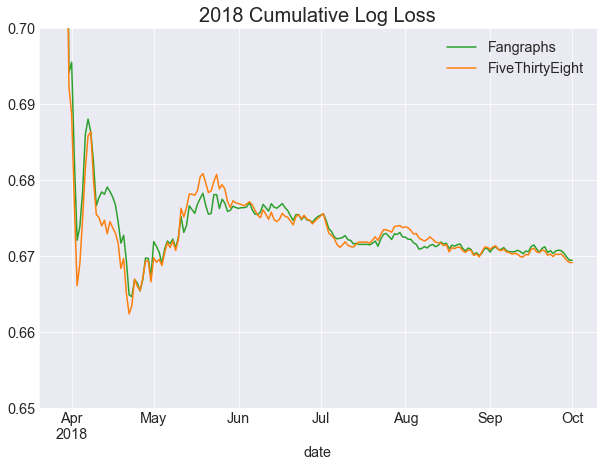

In [41]:
create_cum_logloss_plot(2018)